In [3]:
#Import Libraries needed
from pathlib import Path
from os import listdir
from os.path import isfile, join
import json
import statistics
from scipy.stats import entropy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#Global Variables
p_tc_path = Path('./../Data/Processed_Transcripts')

In [9]:
#Functions from the other file
def get_data(transcript_number):
    """Takes transcript number and returns a data dictionary for the corresponding transcript"""
    name = ''
    if transcript_number/10 < 1:
        name = 'p_tc_' + '00' + str(transcript_number) + '.json'
    elif transcript_number/100 < 1:
        name = 'p_tc_' + '0' + str(transcript_number) + '.json'
    else:
        name = 'p_tc_' + str(transcript_number) + '.json'
    file_name = p_tc_path / name
    with open(file_name, 'r') as file:
        data = json.load(file) #ensure_ascii=False ensures us that accents and ~ are maintained
    return data

def calc_total(data):
    """Calculates the total number of words said in the video"""
    return sum(data.values())

def calc_filler(data):
    """Calculates the number of 'Filler' words said in the video"""
    num = 0
    for w, n in data.items():
        if w in ['ah', 'eh', 'hm', 'mm', 'm', 'aa']:
            num += n
    return num

def calc_unique(data):
    """Calculates the number of unique words said in the video"""
    return len(data.keys())

def calc_average(data):
    """Calculates the average number of times a word was used in the video"""
    return sum(data.values()) / len(data.values())

def calc_median(data):
    """Calculates the median number of times a word was used in the video"""
    return statistics.median(data.values())

def calc_entropy(data):
    """Calculates the entropy of the vocabulary used in the video"""
    word_counts = np.array(list(data.values())) #makes it easier to do the probabilities calculation
    probabilities = word_counts / word_counts.sum()
    return entropy(probabilities, base=2)

def calc_ttr(data):
    """Calculates the TTR (unique words / total words) for the data"""
    return len(data.values()) / sum(data.values())


#New function for desired functionality- joins two data dictionaries into one
def join_dict(dict1, dict2):
    for w, n in dict2.items():
        if w in dict1:
            dict1[w] += n
        else:
            dict1[w] = n
    return dict1

In [15]:
#Testing to make sure the function works, and it does!

dict1 = {"A": 1, "B": 2}
dict2 = {"B": 3, "C": 4}

print(join_dict(dict1, dict2))

dict1 = {"A": 1, "B": 2}
dict2 = {"C": 3, "D": 4}

print(join_dict(dict1, dict2))

{'A': 1, 'B': 5, 'C': 4}
{'A': 1, 'B': 2, 'C': 3, 'D': 4}


In [27]:
#For loop to create the data measurements by week

#
data_list = []

for i in range(16): #weeks 1-16
    word_dict = {}
    for j in range(7):
        #print((7*i)+j+1)
        t = get_data((7*i)+j+1)
        word_dict = join_dict(word_dict, t)

    #Calculate results and append as a dictionary
    data_list.append({
        "Week_Number": i+1,
        "Total_Words": calc_total(word_dict),
        "Filler_Words": calc_filler(word_dict),
        "Unique_Words": calc_unique(word_dict),
        "Avg_Word_Freq": calc_average(word_dict),
        #"Med_Word_Freq": calc_median(word_dict), #Commenting out this one since we drop it anyways
        "Entropy": calc_entropy(word_dict),
        "TTR": calc_ttr(word_dict)
    })

#Convert to a dataframe
data_w = pd.DataFrame(data_list)

#Show first 5 rows to make sure things look fine
print(data_w.head())

   Week_Number  Total_Words  Filler_Words  Unique_Words  Avg_Word_Freq  \
0            1         4916           495           918       5.355120   
1            2         4440           319           871       5.097589   
2            3         5203           410           967       5.380558   
3            4         6696           682          1217       5.502054   
4            5         5044           463           909       5.548955   

   Med_Word_Freq   Entropy       TTR  
0            1.0  7.659177  0.186737  
1            1.0  7.724430  0.196171  
2            1.0  7.722396  0.185854  
3            1.0  7.796099  0.181750  
4            1.0  7.614258  0.180214  


In [49]:
#Import daily data and calculate minutes recorded per week

data_d = pd.read_csv("./../data/clean_data.csv", index_col="Video_Number")

#calculate week number based on day
week_num = []
for i in range(112):
    week_num.append((i // 7)+1)

data_d["Week_Number"] = week_num #make new column

#Create aggregated calculation of Length_Minutes by Week_Number
Tot_Min = pd.DataFrame(data_d.groupby("Week_Number")["Length_Minutes"].sum()) #Value wanted

#This calculation is to make sure the data is consistent by checking the total word value calculated both ways (since it can be calculated both ways)
#data_d.groupby("Week_Number")["Total_Words"].sum() #uncomment to see results

data = pd.merge(data_w, Tot_Min, on="Week_Number", how="inner") #Join two datasets

data.head() #Let's look at what we have to make sure everything is fine, it is!

,Week_Number,Total_Words,Filler_Words,Unique_Words,Avg_Word_Freq,Med_Word_Freq,Entropy,TTR,Length_Minutes
0,1,4916,495,918,5.355120,1.0,7.659177,0.186737,63.20
1,2,4440,319,871,5.097589,1.0,7.724430,0.196171,58.23
2,3,5203,410,967,5.380558,1.0,7.722396,0.185854,67.84
3,4,6696,682,1217,5.502054,1.0,7.796099,0.181750,84.10
4,5,5044,463,909,5.548955,1.0,7.614258,0.180214,58.80


In [55]:
#Now let's calculate the measured we had last time
#Note: Words_Per_Minute = WPM

#Basic PM measures
data["WPM"] = data["Total_Words"] / data["Length_Minutes"]
data["Filler_WPM"] = data["Filler_Words"] / data["Length_Minutes"]
data["Unique_WPM"] = data["Unique_Words"] / data["Length_Minutes"]

#I'm also interested in looking at filler words / total_words as a % rate over time (to normalize that as well with spoken words instead of time passed)
data["Filler_Perc"] = data["Filler_Words"] / data["Total_Words"]

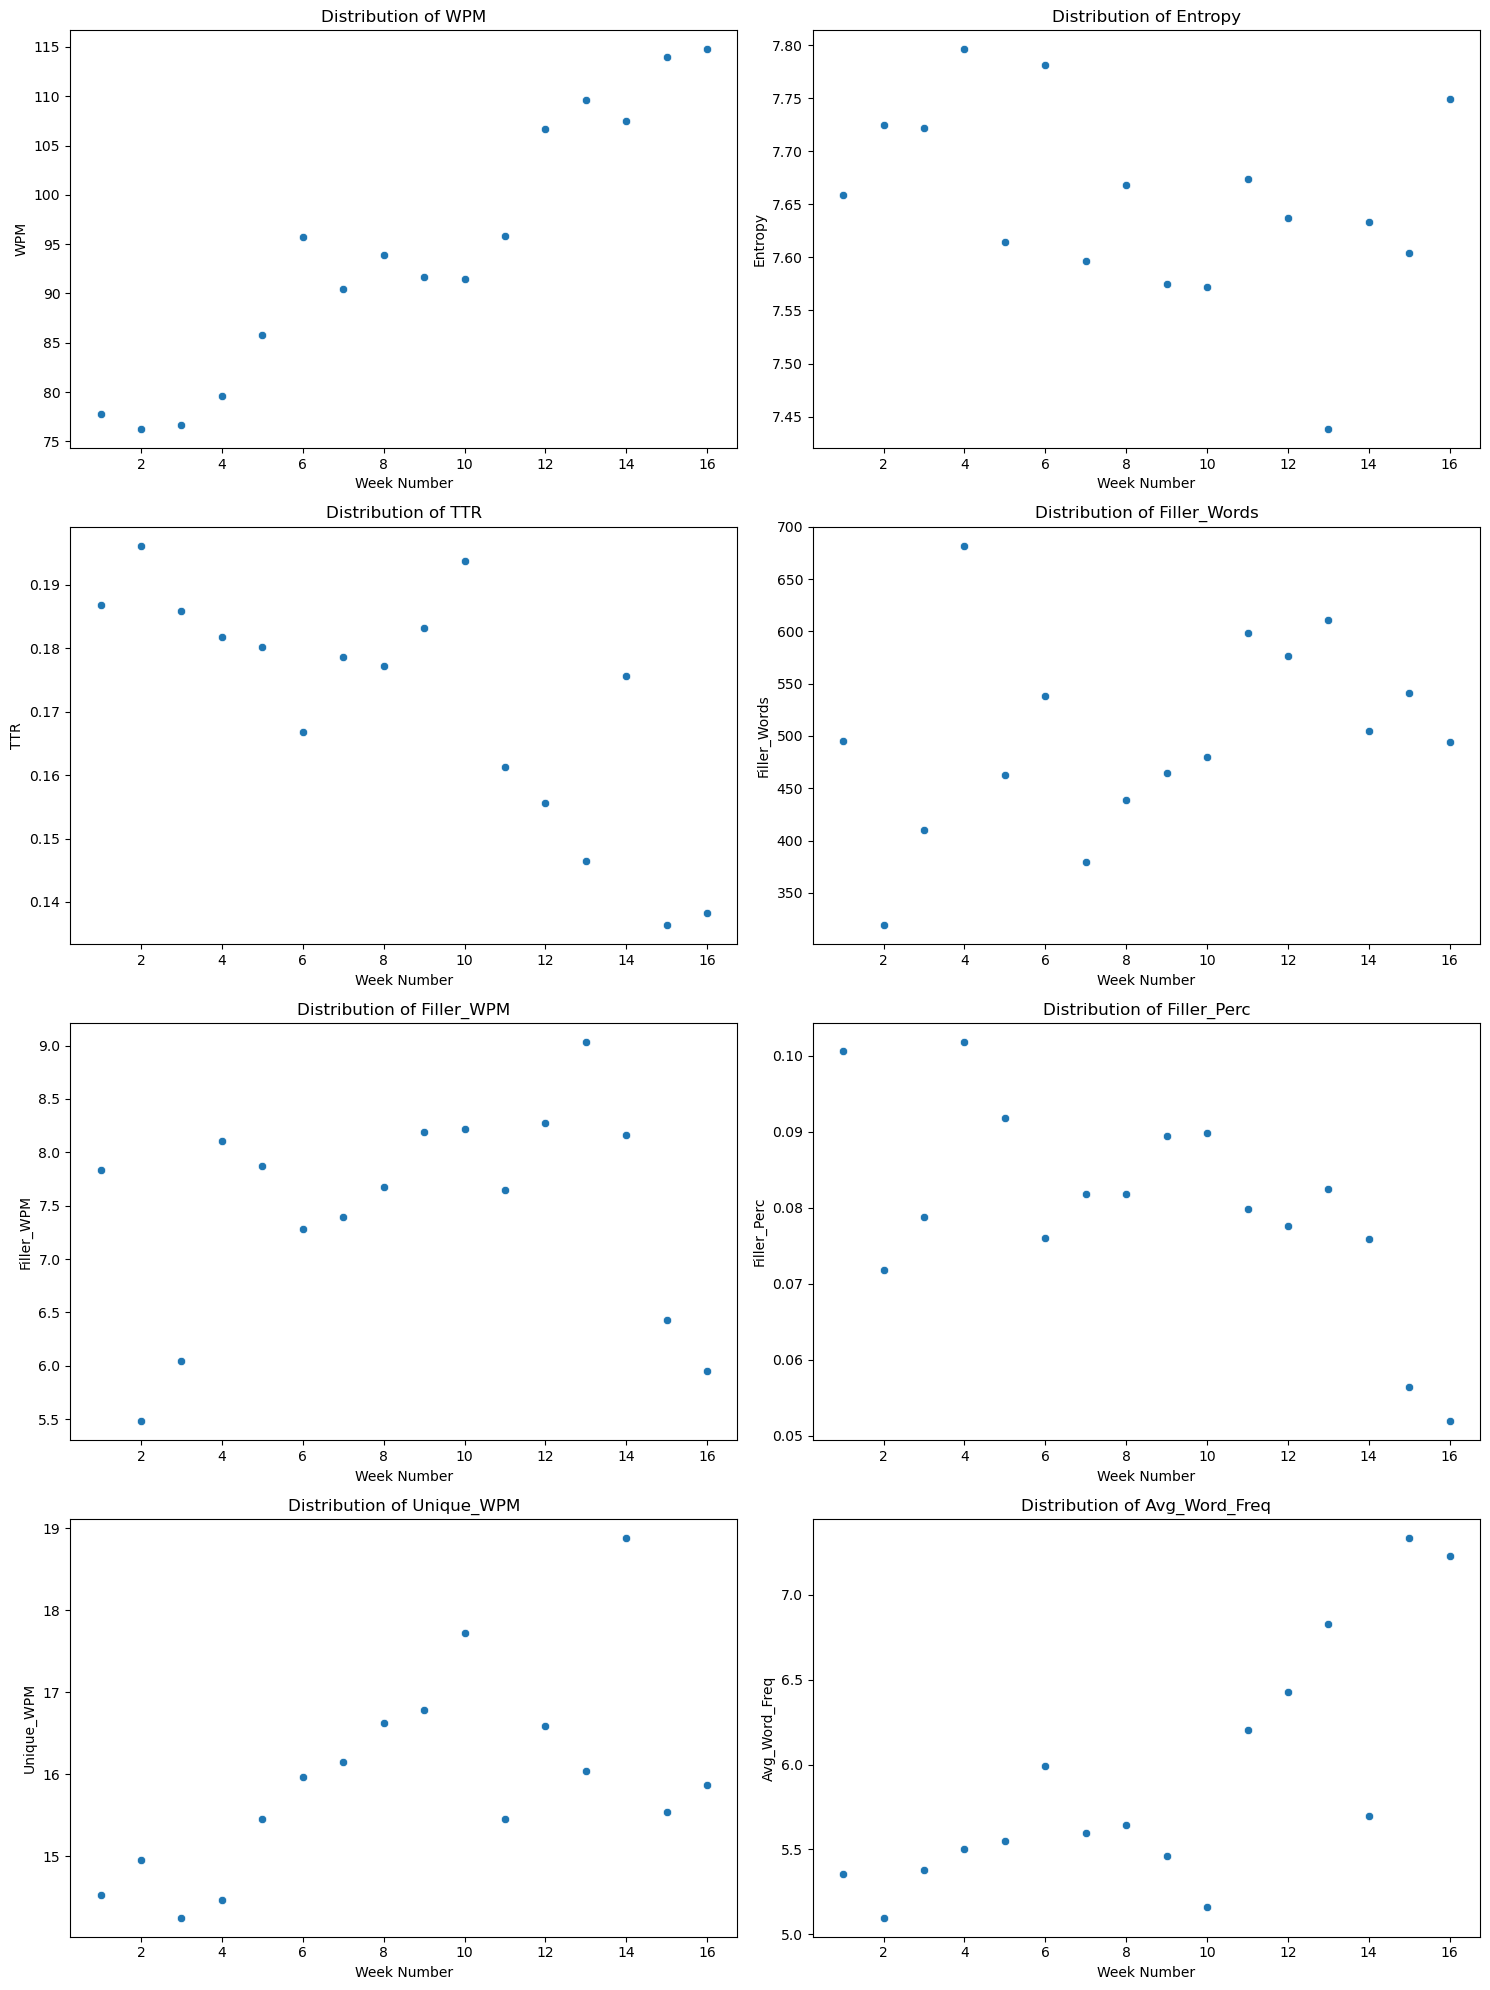

In [59]:
#Now let's visualize!

#Creating a 4 row, 2 col grid of linecharts to show the patterns over time all next to eachother (and shorten workbook size)
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.subplots_adjust(hspace=0.4)

#List of variables we want to look at
categories = ["WPM", "Entropy", "TTR", "Filler_Words", "Filler_WPM", "Filler_Perc", 
              "Unique_WPM", "Avg_Word_Freq"]

for i in range(8):
    row, col = divmod(i, 2)  # Get grid position
    sns.scatterplot(data=data, x="Week_Number", y=categories[i], ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {categories[i]}')  # Set title for each boxplot according to variable name
    axes[row, col].set_xlabel("Week Number")

plt.tight_layout()
plt.show()

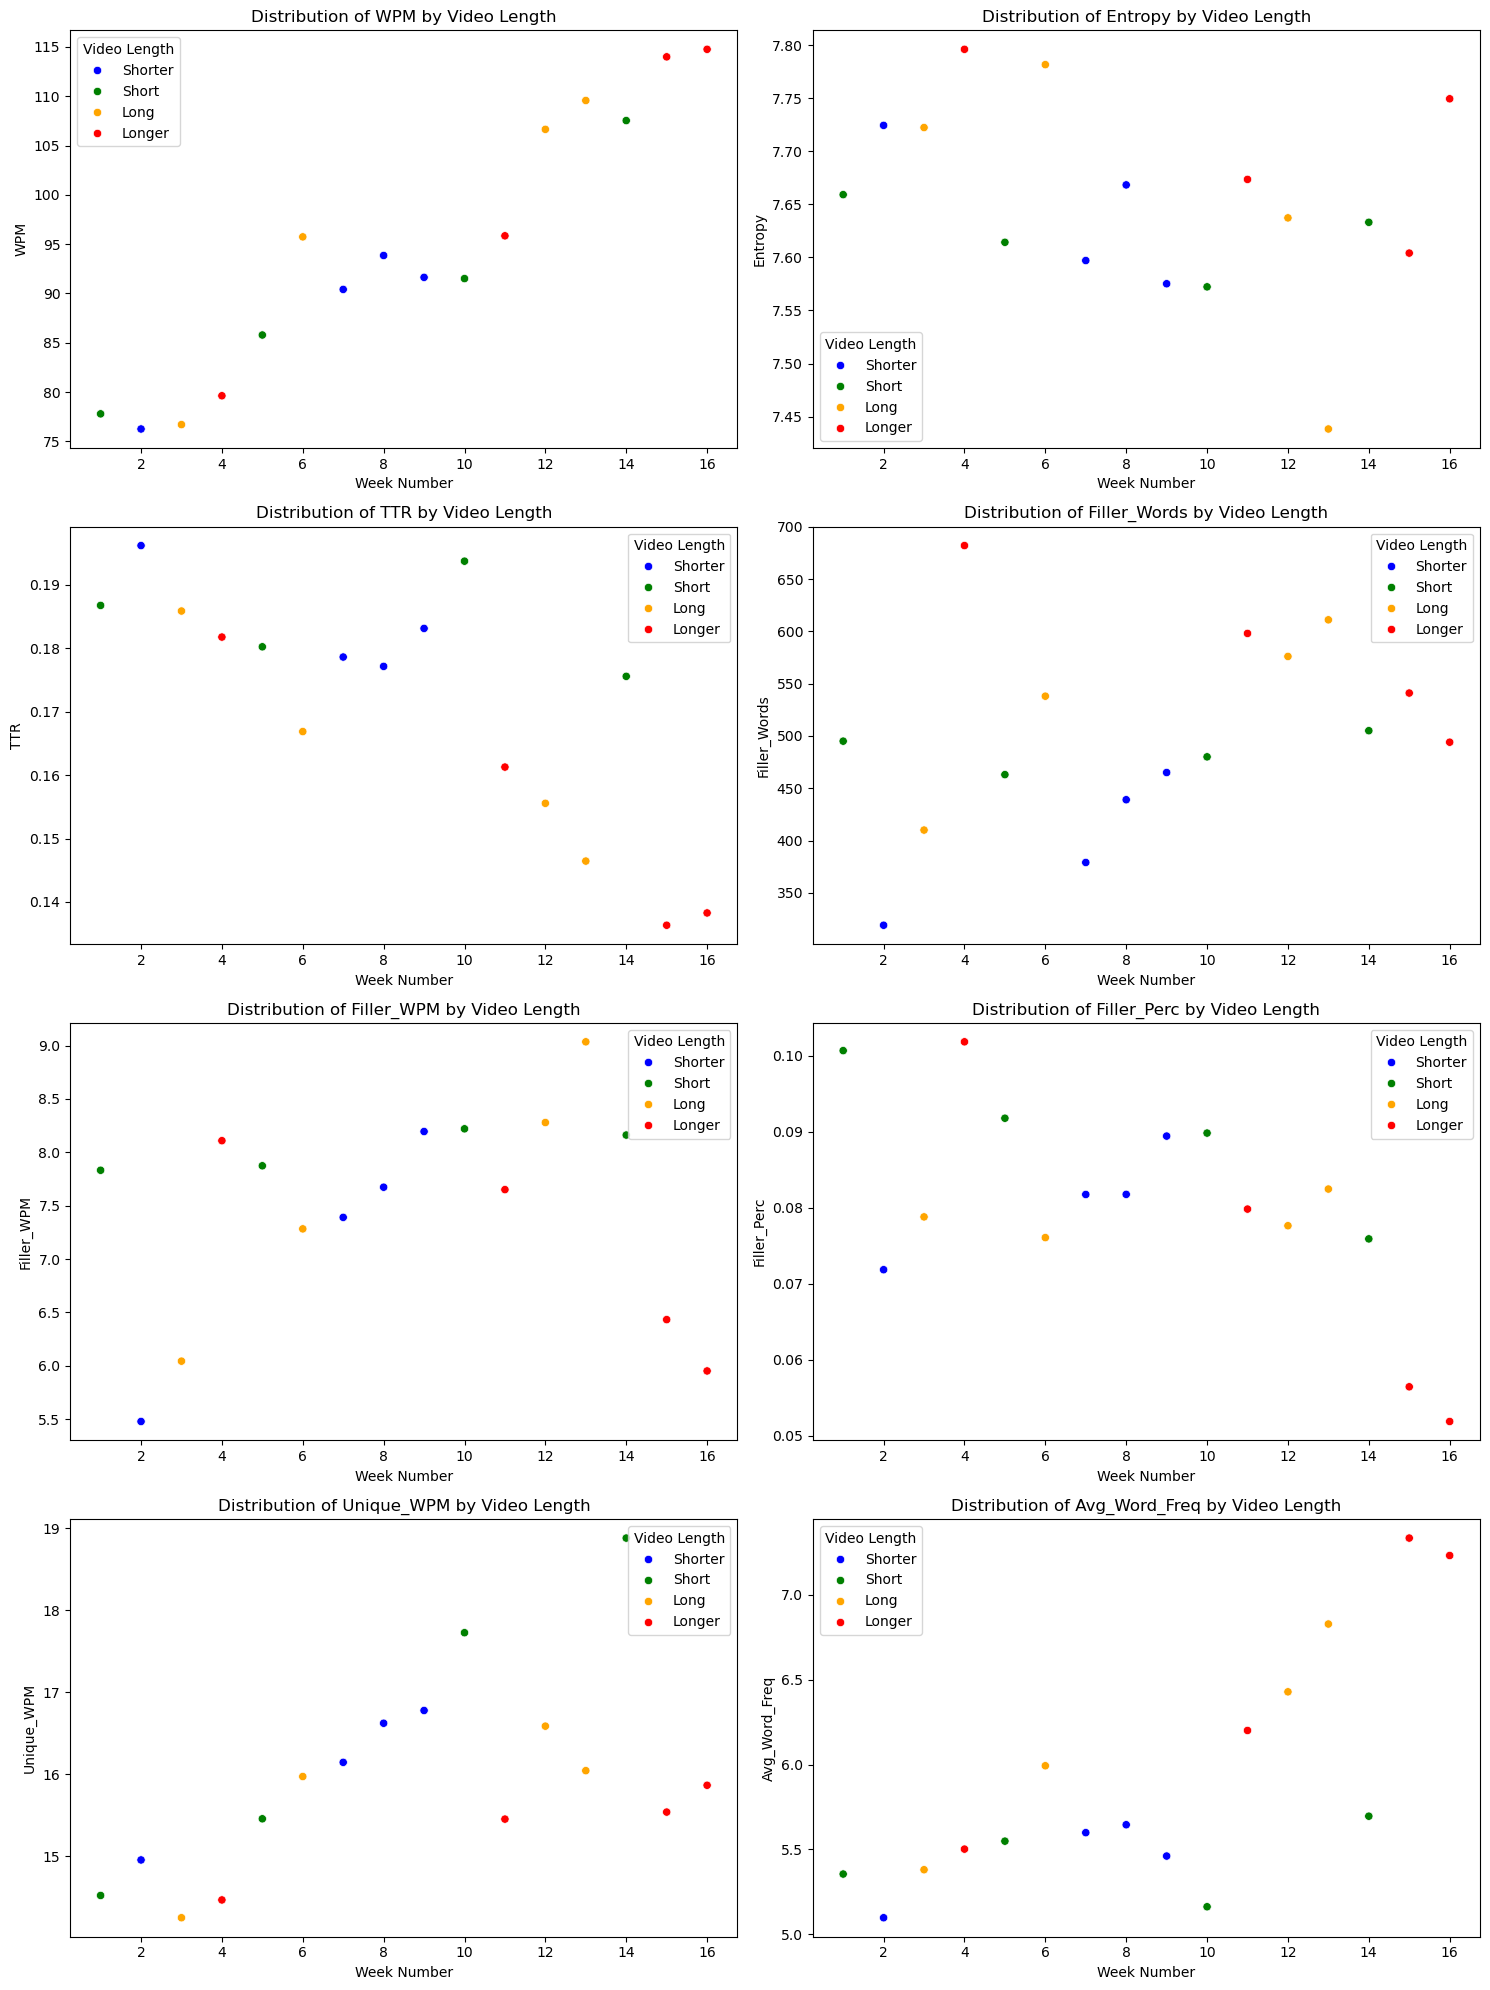

In [65]:
#I want to look at these based on video length, the Unique_WPM measure doesn't have a clear relationship

data["Quantile_Length"] = pd.qcut(data["Length_Minutes"], q=4, labels=["Shorter", "Short", "Long", "Longer"]) #couldn't find great category names here

#Same code as above
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.subplots_adjust(hspace=0.4)

#List of variables we want to look at
categories = ["WPM", "Entropy", "TTR", "Filler_Words", "Filler_WPM", "Filler_Perc", 
              "Unique_WPM", "Avg_Word_Freq"]

#Make this easier to see patterns
colors = {
    "Shorter" : "Blue", 
    "Short" : "Green",
    "Long" : "Orange", 
    "Longer" : "Red"
}

for i in range(8):
    row, col = divmod(i, 2)  # Get grid position
    sns.scatterplot(data=data, x="Week_Number", y=categories[i], ax=axes[row, col], hue="Quantile_Length", palette=colors)
    axes[row, col].set_title(f'Distribution of {categories[i]} by Video Length')  # Set title for each boxplot according to variable name
    axes[row, col].set_xlabel("Week Number")
    axes[row, col].legend(title="Video Length")

plt.tight_layout()
plt.show()

In [73]:
#Calculations to be able to share on reports

wpm = data["WPM"]
print(wpm[0], wpm[15], 100*(wpm[15]-wpm[0])/wpm[0])

fp = data["Filler_Perc"]
print(fp[0], fp[15], 100*(fp[15]-fp[0])/fp[0])

77.78481012658227 114.75903614457832 47.533992765202406
0.10069161920260375 0.05186351706036745 -48.492717198229016
